# 1 Development of Shor error correcting circuit

In [ ]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import Initialize
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel,pauli_error
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2, FakeGuadalupeV2, FakeVigoV2, FakeAuckland,FakePerth,FakeTorontoV2
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, random_statevector
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import display
simulator_aer=AerSimulator()

Following the structure of the Shor code, this cell implements the whole code at once

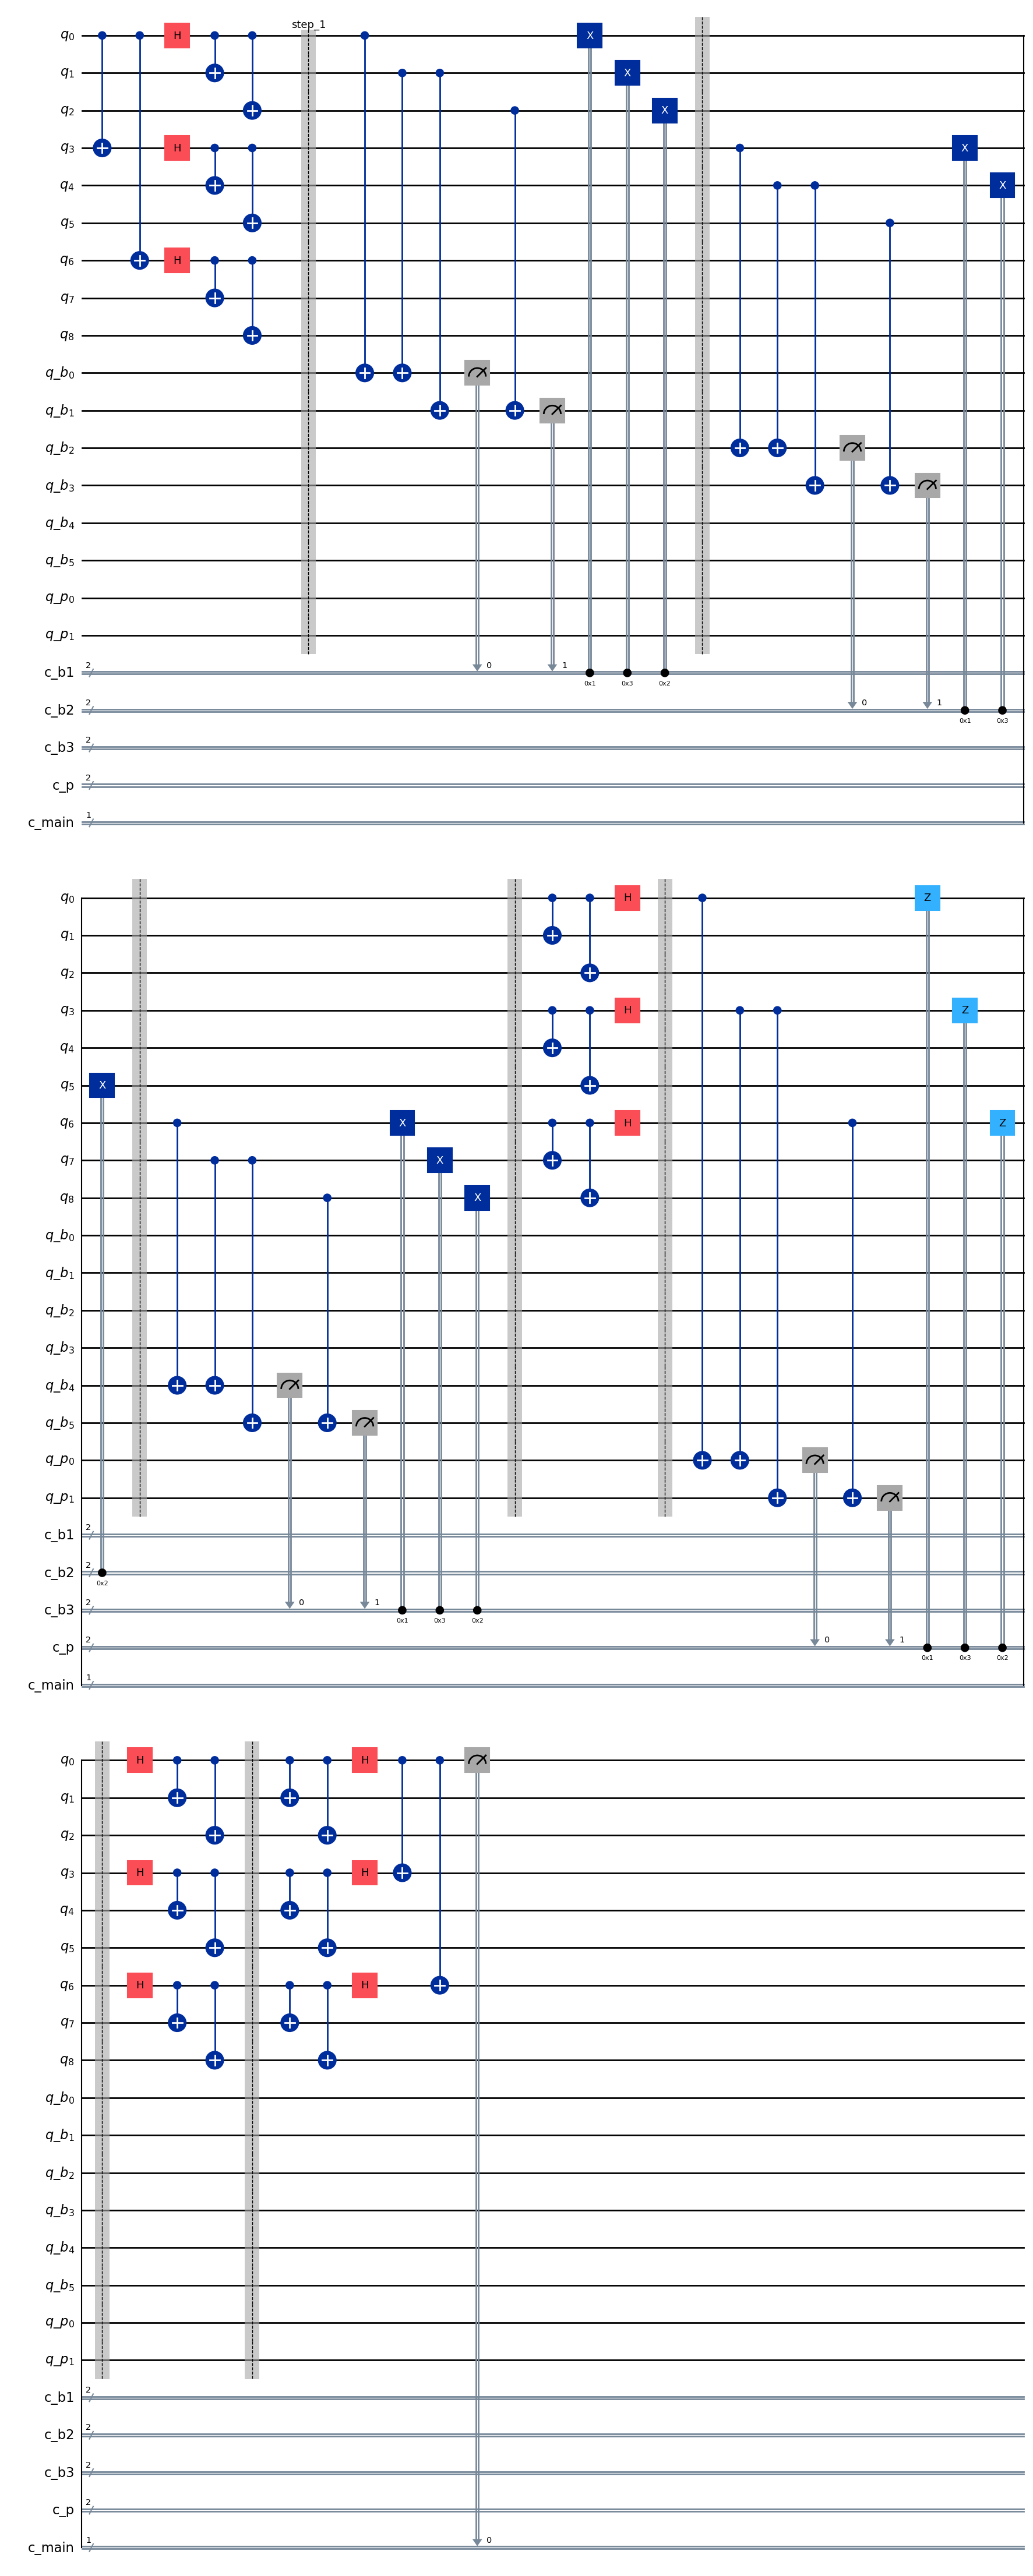

In [ ]:
qr = QuantumRegister(9,"q")
qr_b=QuantumRegister(6, 'q_b')
qr_p=QuantumRegister(2, 'q_p')
cr_b1 = ClassicalRegister(2, "c_b1")
cr_b2 = ClassicalRegister(2, "c_b2")
cr_b3 = ClassicalRegister(2, "c_b3")
cr_p= ClassicalRegister(2, "c_p")
cr_main = ClassicalRegister(1, "c_main")  # For the first qubit

qc = QuantumCircuit(qr,qr_b,qr_p,cr_b1,cr_b2,cr_b3,cr_p,cr_main)

# --- ENCODING ---
qc.cx(qr[0],qr[3])
qc.cx(qr[0],qr[6])

qc.h(qr[0])
qc.h(qr[3])
qc.h(qr[6])

qc.cx(qr[0],qr[1])
qc.cx(qr[0],qr[2])

qc.cx(qr[3],qr[4])
qc.cx(qr[3],qr[5])

qc.cx(qr[6],qr[7])
qc.cx(qr[6],qr[8])
qc.save_statevector(label="step_1")

#bitflip error here

#----BITFLIP CORRECTION----
#Measure parities of the three triplets q0q1q2 using qb0 and qb1, q3q4q5 using qb2 and qb3, q6q7q8 using qb4 and qb5. Then, apply the conditional x gates based on the outcome

#first triplet
qc.cx(qr[0],qr_b[0])
qc.cx(qr[1],qr_b[0])
qc.cx(qr[1],qr_b[1])
qc.cx(qr[2],qr_b[1])
qc.measure(qr_b[0], cr_b1[0])
qc.measure(qr_b[1], cr_b1[1])
qc.x(qr[0]).c_if(cr_b1, 1)
qc.x(qr[1]).c_if(cr_b1, 3)
qc.x(qr[2]).c_if(cr_b1, 2)
qc.barrier()

#second triplet
qc.cx(qr[3],qr_b[2])
qc.cx(qr[4],qr_b[2])
qc.cx(qr[4],qr_b[3])
qc.cx(qr[5],qr_b[3])
qc.measure(qr_b[2], cr_b2[0])
qc.measure(qr_b[3], cr_b2[1])
qc.x(qr[3]).c_if(cr_b2, 1)
qc.x(qr[4]).c_if(cr_b2, 3)
qc.x(qr[5]).c_if(cr_b2, 2)
qc.barrier()

#third triplet
qc.cx(qr[6],qr_b[4])
qc.cx(qr[7],qr_b[4])
qc.cx(qr[7],qr_b[5])
qc.cx(qr[8],qr_b[5])
qc.measure(qr_b[4], cr_b3[0])
qc.measure(qr_b[5], cr_b3[1])
qc.x(qr[6]).c_if(cr_b3, 1)
qc.x(qr[7]).c_if(cr_b3, 3)
qc.x(qr[8]).c_if(cr_b3, 2)
qc.barrier()
#----PHASEFLIP CORRECTION----

#phaseflip error here

#Partially uncode qubit
qc.cx(qr[0],qr[1])
qc.cx(qr[0],qr[2])

qc.cx(qr[3],qr[4])
qc.cx(qr[3],qr[5])

qc.cx(qr[6],qr[7])
qc.cx(qr[6],qr[8])

qc.h(qr[0])
qc.h(qr[3])
qc.h(qr[6])

#Compute phase parities and store them in the ancillas
qc.barrier()

qc.cx(qr[0],qr_p[0])
qc.cx(qr[3],qr_p[0])
qc.cx(qr[3],qr_p[1])
qc.cx(qr[6],qr_p[1])
qc.measure(qr_p[0], cr_p[0])
qc.measure(qr_p[1], cr_p[1])
qc.z(qr[0]).c_if(cr_p, 1)
qc.z(qr[3]).c_if(cr_p, 3)
qc.z(qr[6]).c_if(cr_p, 2)
qc.barrier()

#Reencode qubit

qc.h(qr[0])
qc.h(qr[3])
qc.h(qr[6])

qc.cx(qr[0],qr[1])
qc.cx(qr[0],qr[2])

qc.cx(qr[3],qr[4])
qc.cx(qr[3],qr[5])

qc.cx(qr[6],qr[7])
qc.cx(qr[6],qr[8])
# --- DECODING ---
qc.barrier()

qc.cx(qr[0],qr[1])
qc.cx(qr[0],qr[2])

qc.cx(qr[3],qr[4])
qc.cx(qr[3],qr[5])

qc.cx(qr[6],qr[7])
qc.cx(qr[6],qr[8])

qc.h(qr[0])
qc.h(qr[3])
qc.h(qr[6])

qc.cx(qr[0],qr[3])
qc.cx(qr[0],qr[6])

qc.measure(qr[0], cr_main[0])

display(qc.draw(output="mpl", idle_wires=False, justify='left'))


# 2. Simulations with fake provider



In [13]:
def run_fake(qc,device_backend,noise_model=None,Nshots=1024,optim=0):
    """
    Function that runs a given quantum circuit in the specified backend with/without noise and using Nshots
    
    Args:
        QuantumCircuit (with measurements)
        device_backend(provider)
        noise_model(True or None); by default None (without noise)
        Nshots(integer); by default 1024 shots
        Optim(integer,0,1,2): optimization level for transpilation, by default 0
        
    Returns:
        Transpiled QuantumCircuit
        counts(dictionary)
    """
    sim_faked = AerSimulator.from_backend(device_backend)
    qc_transpiled = transpile(qc, device_backend,optimization_level=optim) 
    if noise_model == True: #to make the difference explicit 
        result = sim_faked.run(qc_transpiled,shots=Nshots).result()
    else: 
        result = sim_faked.run(qc_transpiled,shots=Nshots,noise_model=None).result()
    counts = result.get_counts()

    return qc_transpiled,counts

The main difference between this following function and the previous circuit is the fact that now initialization of the state is included, as well as obtaining the counts. Shor's code assumes that each triplet experiences at most one bit flip error per correction cycle, and at most one triplet experiences a phase-flip error per correction cycle. This means, we can implement up to 3 x gates and one z gate at the same time. 

In order to ease the following calculations, I will assume each triplet is symmetrical in the sense that, only one of the three triplets will be studied for its performance for computational ease. In fact, the study performed on the bitflip error correction code will be repeated for the first triplet, including a possible z gate error in that triplet to see how it affects the performance.

In [ ]:
def shor_error_correction(psi, device_backend,d=False, x_a=False,x_b=False,x_c=False,z_a=False, noise_model=None, Nshots=1024, optim=0):
    qr = QuantumRegister(9,"q")
    qr_b=QuantumRegister(6, 'q_b')
    qr_p=QuantumRegister(2, 'q_p')
    cr_main = ClassicalRegister(1, "c_main") 
    cr_b1 = ClassicalRegister(2, "c_b1")
 
    cr_p= ClassicalRegister(2, "c_p")
    qc = QuantumCircuit(qr,qr_b,qr_p,cr_b1,cr_p,cr_main)

    # Initialize the state
    init_gate = Initialize(psi)
    qc.append(init_gate, [qr[0]])
    qc.barrier()

    # --- ENCODING ---
    qc.cx(qr[0],qr[3])
    qc.cx(qr[0],qr[6])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    #errors here
    if x_a:
        qc.x(qr[0])
    if x_b:
        qc.x(qr[1])
    if x_c:
        qc.x(qr[2]) 

    qc.barrier()

    #----BITFLIP CORRECTION----
    #Measure parities of the three triplets q0q1q2 using qb0 and qb1, q3q4q5 using qb2 and qb3, q6q7q8 using qb4 and qb5. Then, apply the conditional x gates based on the outcome

    if d:
        #first triplet
        qc.cx(qr[0],qr_b[0])
        qc.cx(qr[1],qr_b[0])
        qc.cx(qr[1],qr_b[1])
        qc.cx(qr[2],qr_b[1])
        qc.measure(qr_b[0], cr_b1[0])
        qc.measure(qr_b[1], cr_b1[1])
        qc.x(qr[0]).c_if(cr_b1, 1)
        qc.x(qr[1]).c_if(cr_b1, 3)
        qc.x(qr[2]).c_if(cr_b1, 2)
        qc.barrier()

    #Z error
    if z_a:
        qc.z(qr[0])

    #Partially uncode qubit
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    #----PHASEFLIP CORRECTION----

    if d:

        #Compute phase parities and store them in the ancillas
        qc.barrier()

        qc.cx(qr[0],qr_p[0])
        qc.cx(qr[3],qr_p[0])
        qc.cx(qr[3],qr_p[1])
        qc.cx(qr[6],qr_p[1])
        qc.measure(qr_p[0], cr_p[0])
        qc.measure(qr_p[1], cr_p[1])
        qc.h(qr[0])
        qc.h(qr[3])
        qc.h(qr[6])
        qc.z(qr[0]).c_if(cr_p, 1)
        qc.z(qr[3]).c_if(cr_p, 3)
        qc.z(qr[6]).c_if(cr_p, 2)
        qc.h(qr[0])
        qc.h(qr[3])
        qc.h(qr[6])

    qc.barrier()

    #Reencode qubit

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    # --- DECODING ---
    qc.barrier()

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[3])
    qc.cx(qr[0],qr[6])


    # Uncompute initialization
    qc.append(init_gate.gates_to_uncompute(), [qr[0]])
    qc.measure(qr[0], cr_main[0])

    #display(qc.draw("mpl")) 

    # Run circuit
    qc_transpiled, counts = run_fake(qc, device_backend, noise_model, Nshots, optim)
    return qc_transpiled, counts

alpha=1/2
beta = np.sqrt(3)/2
psi=[alpha, beta]

qc_transpiled, counts = shor_error_correction(psi, FakeTorontoV2(),d=True, z_a=True,x_b=True)
print(counts)


{'0 01 11': 1024}


The following function follows the scheme of previous code to determine the fidelities and do a performance study

In [15]:
def evaluate_fidelity_shor(psi_list, e=False, d=False, x_a=False, x_b=False, x_c=False, z_a=False):
    num_trials = len(psi_list)
    all_counts = {}
    probabilities = {}
    probabilities_0 = {}

    for i, psi in enumerate(psi_list):
        _, counts = shor_error_correction(psi, FakeTorontoV2(), d=d, x_a=x_a, x_b=x_b, x_c=x_c, z_a=z_a, noise_model=e)
        all_counts[f"State {i+1}"] = counts
        total_shots = sum(counts.values())

        state_probabilities = {}
        prob_0 = 0

        for outcome in counts:
            state_probabilities[outcome] = counts[outcome] / total_shots
            if outcome.startswith("0"):
                prob_0 += state_probabilities[outcome]

        probabilities[f"State {i+1}"] = state_probabilities
        probabilities_0[f"State {i+1}"] = prob_0

    fidelity = sum(probabilities_0.values()) / num_trials
    std_dev = np.std(list(probabilities_0.values()), ddof=1)
    uncertainty = std_dev / np.sqrt(num_trials)

    return fidelity, uncertainty

psi_list = [random_statevector(2) for _ in range(2)]
fidelity, uncertainty = evaluate_fidelity_shor(psi_list, e=False, d=True, x_a=False, x_b=True, z_a=True)
print(fidelity)


1.0


In [16]:
def store_all_fidelities_shor():
    results = {}
    booleans = [False, True]
    psi_list = [random_statevector(2) for _ in range(4)]

    for e in booleans:
        for d in booleans:
            for z_a in booleans:
                for num_x in range(4):
                    fidelity_values = []
                    uncertainty_values = []

                    for x_comb in combinations(["x_a", "x_b", "x_c"], num_x):
                        x_a, x_b, x_c = "x_a" in x_comb, "x_b" in x_comb, "x_c" in x_comb
                        fidelity, uncertainty = evaluate_fidelity_shor(psi_list, e=e, d=d, x_a=x_a, x_b=x_b, x_c=x_c, z_a=z_a)
                        fidelity_values.append(fidelity)
                        uncertainty_values.append(uncertainty)

                    fidelity_avg = float(np.mean(fidelity_values))
                    uncertainty_avg = float(np.sqrt(np.sum(np.array(uncertainty_values) ** 2)) / len(uncertainty_values))
                    results[f"Noise={e}, Correction={d}, Z={z_a}, X Gates={num_x}"] = (fidelity_avg, uncertainty_avg)

    return results

results=store_all_fidelities_shor()
print(results)


{'Noise=False, Correction=False, Z=False, X Gates=0': (1.0, 0.0), 'Noise=False, Correction=False, Z=False, X Gates=1': (0.8373209635416666, 0.054646370574253256), 'Noise=False, Correction=False, Z=False, X Gates=2': (0.677734375, 0.07514324284519637), 'Noise=False, Correction=False, Z=False, X Gates=3': (0.50634765625, 0.162443620731569), 'Noise=False, Correction=False, Z=True, X Gates=0': (0.34765625, 0.1817713987966521), 'Noise=False, Correction=False, Z=True, X Gates=1': (0.2696126302083333, 0.08621324426597697), 'Noise=False, Correction=False, Z=True, X Gates=2': (0.20882161458333334, 0.06374825696148295), 'Noise=False, Correction=False, Z=True, X Gates=3': (0.149658203125, 0.04424696634242178), 'Noise=False, Correction=True, Z=False, X Gates=0': (1.0, 0.0), 'Noise=False, Correction=True, Z=False, X Gates=1': (1.0, 0.0), 'Noise=False, Correction=True, Z=False, X Gates=2': (0.5208333333333334, 0.09428654885713982), 'Noise=False, Correction=True, Z=False, X Gates=3': (0.508056640625,

In [17]:
def extract_success_probabilities_shor(results, e, d, z_a):
    probabilities = [0] * 4
    uncertainties = [0] * 4
    for num_x in range(4):
        key = f"Noise={e}, Correction={d}, Z={z_a}, X Gates={num_x}"
        if key in results:
            probabilities[num_x] = results[key][0]
            uncertainties[num_x] = results[key][1]
    return probabilities, uncertainties


In [ ]:
def plot_fidelity_curves_shor(results, edz_tuples, title="Success probability vs p_x", legend_labels=None):
    all_outputs = {}
    px_values = np.linspace(0, 1, 100)

#iterate over noise and noiseless, correction and no correction, z and no z
    for (e, d, z_a), label in zip(edz_tuples, legend_labels): #the zip function pairs elements of two different lists
        probabilities, uncertainties = extract_success_probabilities_shor(results, e, d, z_a)        

        P_total_values = []
        P_total_uncertainties = []

        for px in px_values:
            P_total = (
                probabilities[0] * (1 - px) ** 3 +
                probabilities[1] * 3 * px * (1 - px) ** 2 +
                probabilities[2] * 3 * px ** 2 * (1 - px) +
                probabilities[3] * px ** 3
            )
            P_uncertainty = np.sqrt(
                (uncertainties[0] * (1 - px) ** 3) ** 2 +
                (uncertainties[1] * 3 * px * (1 - px) ** 2) ** 2 +
                (uncertainties[2] * 3 * px ** 2 * (1 - px)) ** 2 +
                (uncertainties[3] * px ** 3) ** 2
            )
            P_total_values.append(P_total)
            P_total_uncertainties.append(P_uncertainty)

        all_outputs[(e, d, z_a)] = (np.array(P_total_values), np.array(P_total_uncertainties))
        plt.errorbar(px_values, P_total_values, yerr=0.1 * np.array(P_total_uncertainties), fmt='-', capsize=2, label=label)

    plt.xlabel("$p_x$", fontsize=15)
    plt.ylabel("Success probability", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    #plt.title(title)
    plt.grid()
    plt.show()
    return px_values, all_outputs


In [19]:
edz_tuples = [
    (False, False, False),
    (False, False, True),
    (False, True, False),
    (False, True, True),
    (True, False, False),
    (True, False, True),
    (True, True, False),
    (True, True, True),
]

legend_labels = [
    "Noiseless, no correction, Z=0",
    "Noiseless, no correction, Z=1",
    "Noiseless, correction, Z=0",
    "Noiseless, correction, Z=1",
    "Noisy, no correction, Z=0",
    "Noisy, no correction, Z=1",
    "Noisy, correction, Z=0",
    "Noisy, correction, Z=1",
]


Correction: fidelidades=[1.0, 1.0, 0.5208333333333334, 0.508056640625], incertidumbres=[0.0, 0.0, 0.09428654885713982, 0.15466078967542787]
No correction: fidelidades=[1.0, 0.8373209635416666, 0.677734375, 0.50634765625], incertidumbres=[0.0, 0.054646370574253256, 0.07514324284519637, 0.162443620731569]


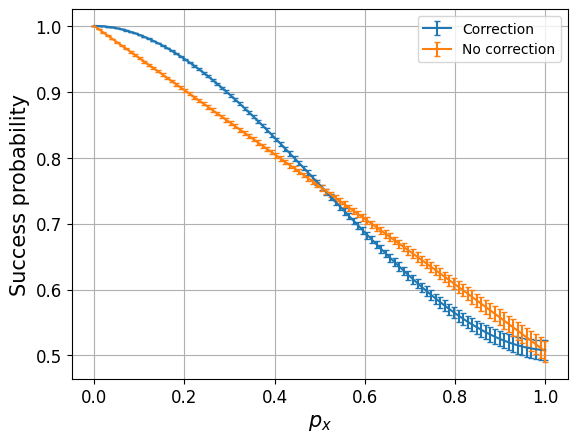

Correction: fidelidades=[0.4736328125, 0.475341796875, 0.4532877604166667, 0.454345703125], incertidumbres=[0.06319423391379289, 0.044257841510195184, 0.04017748934966716, 0.07549631882844837]
No correction: fidelidades=[0.483154296875, 0.47998046875, 0.4735514322916667, 0.440673828125], incertidumbres=[0.0680393539225654, 0.03813233768746128, 0.044153169332963156, 0.07652929195683805]


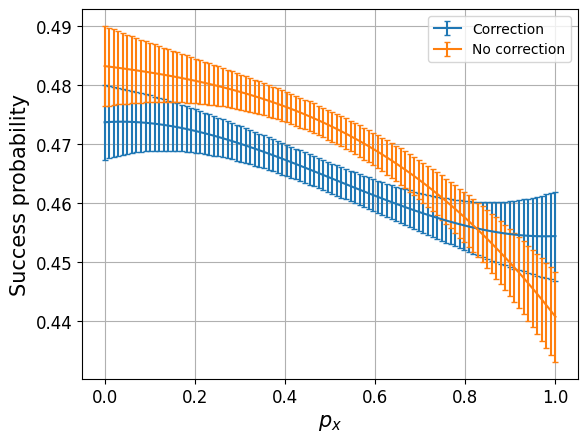

Correction: fidelidades=[1.0, 1.0, 0.5201822916666666, 0.512939453125], incertidumbres=[0.0, 0.0, 0.09291688414407091, 0.16386686498574615]
No correction: fidelidades=[0.34765625, 0.2696126302083333, 0.20882161458333334, 0.149658203125], incertidumbres=[0.1817713987966521, 0.08621324426597697, 0.06374825696148295, 0.04424696634242178]


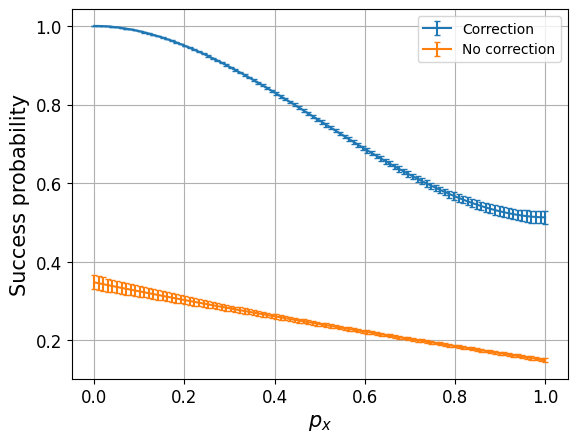

Correction: fidelidades=[0.4658203125, 0.4589029947916667, 0.4549967447916667, 0.464111328125], incertidumbres=[0.0762657174342556, 0.044121208909389024, 0.05067739708108412, 0.07558258864075518]
No correction: fidelidades=[0.439697265625, 0.462646484375, 0.4844563802083333, 0.440673828125], incertidumbres=[0.05008374988469427, 0.03356631898006489, 0.02877880790843619, 0.02226325128406054]


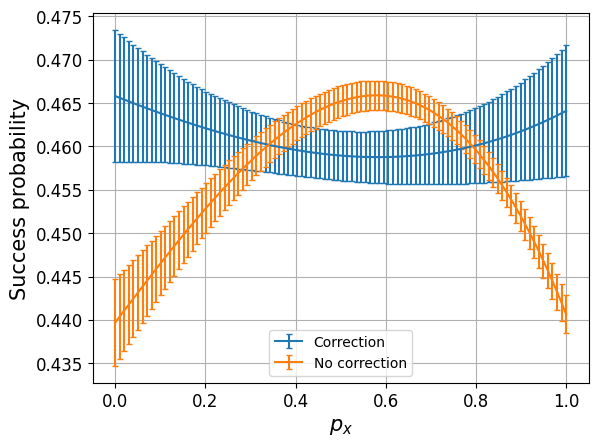

In [ ]:
#Correction vs no correction, noiseless, Z=0
_ =plot_fidelity_curves_shor(
    results,
    edz_tuples=[(False, True, False), (False, False, False)],
    title="Success probability vs p_x, Noiseless, no z",
    legend_labels=["Correction", "No correction"]
)

#Correction vs no correction, noise, Z=0
_ =plot_fidelity_curves_shor(
    results,
    edz_tuples=[(True, True, False), (True, False, False)],
    title="Success probability vs p_x, Noise, no z",
    legend_labels=["Correction", "No correction"]
)

#Correction vs no correction, noiseless, Z=1
_ =plot_fidelity_curves_shor(
    results,
    edz_tuples=[(False, True, True), (False, False, True)],
    title="Success probability vs p_x, Noiseless, z",
    legend_labels=["Correction", "No correction"]
)

#Correction vs no correction, noise, Z=1
_ =plot_fidelity_curves_shor(
    results,
    edz_tuples=[(True, True, True), (True, False, True)],
    title="Success probability vs $p_x$, Noise, z",
    legend_labels=["Correction", "No correction"]
)

The next idea is to generate a heatmap in which we can study more deeply the effect of the z gate being added. First, a function is defined in order to compute the success values (only in terms of px for z=0 and z=1)

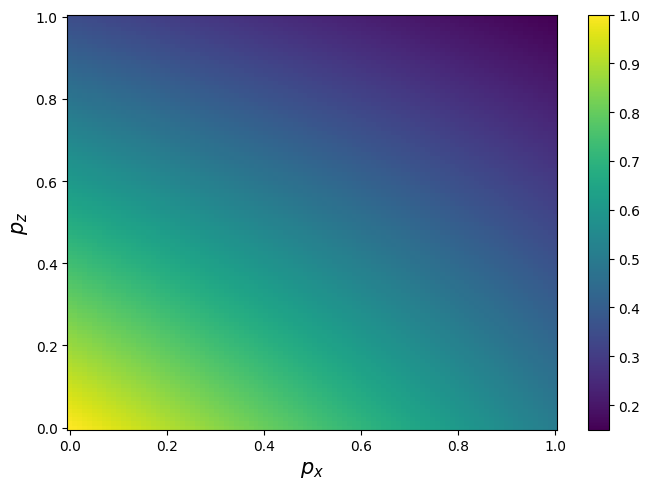

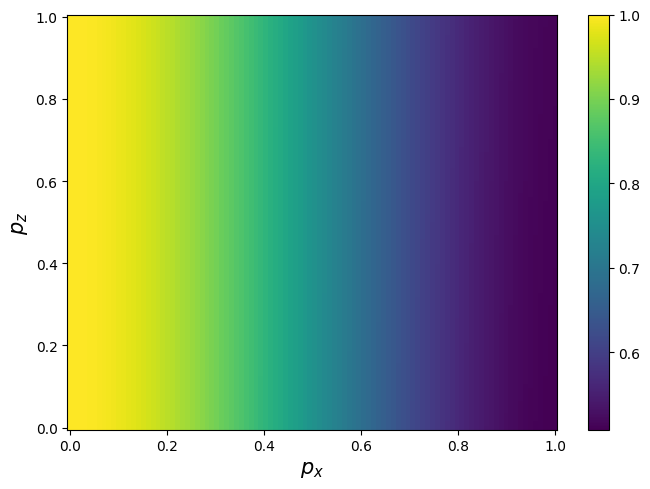

In [25]:
def compute_total_probabilities(results, e, d, z_a):
    probabilities, _ = extract_success_probabilities_shor(results, e, d, z_a)
    px_values = np.linspace(0, 1, 100)
    P_total_values = []

    for px in px_values:
        P_total = (
            probabilities[0] * (1 - px) ** 3 +
            probabilities[1] * 3 * px * (1 - px) ** 2 +
            probabilities[2] * 3 * px ** 2 * (1 - px) +
            probabilities[3] * px ** 3
        )
        P_total_values.append(P_total)

    return np.array(px_values), np.array(P_total_values)

e = False  # Noiseless
pz_vals = np.linspace(0, 1, 100)

for d in [False, True]:  # without and with correction
    px_vals, psuccess_z0 = compute_total_probabilities(results, e, d, z_a=False)
    _, psuccess_z1 = compute_total_probabilities(results, e, d, z_a=True)

    PX, PZ = np.meshgrid(px_vals, pz_vals)
    PZ0 = np.tile(psuccess_z0, (len(pz_vals), 1))
    PZ1 = np.tile(psuccess_z1, (len(pz_vals), 1))
    PSUCCESS = PZ0 * (1 - PZ) + PZ1 * PZ

    # Crear figura independiente
    plt.figure(figsize=(7, 5))
    im = plt.pcolormesh(px_vals, pz_vals, PSUCCESS, shading='auto', cmap='viridis')
    plt.xlabel("$p_x$", fontsize=15)
    plt.ylabel("$p_z$", fontsize=15)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
